# TCC Master BI: Mensurando o Impacto da Presença de Torcida nas Chances de Vitoria do Time da Casa em uma Partida da NBA

## Aluno: Stefanno Ruiz Manni
## Matricula: 201.110.695

## Orientadora: Prof. Manoela Kohler
## Co-Orientador: Prof. Felipe Borges

### Caso a ser estudado:

A NBA (National Basketball Association) é a principal liga de basquete do mundo, disputada nos Estados Unidos e que vem se expandindo internacionalmente ao longo dos ultimos anos.

Devido à grande cultura de dados, enraizada nos esportes estadunidenses, temos a nossa disposição uma infinidade de dados que nos possibilitam entender o jogo nos mínimos detalhes. 

Com a Pandemia do COVID19 surgiram algumas situações únicas que, pela primeira vez, nos permitem mensurar o real impacto que a presença de torcida possui, uma vez que tivemos um número significativo de jogos em quadra neutra.

Esse trabalho visa a criação de modelos de classificacao para a previsão do vencedor de uma partida da NBA e com esses modelos ser capaz de mensurar o real impacto da presenca de torcida em termos de aumentar as chances de vitoria do time da casa. Isso será feito a partir da análise do coeficiente da variavel que indica presenca de torcida.

Vamos utilizar duas abordagens:

1. Utilizar dados de três temporadas sem pandemia e criar a variavél ocupação (indicando quanto da capacidade da arena foi ocupada pelo publico) e entender seu impacto. E esperado que quanto maior o público presente maior as chances de vitoria do time da casa.

2. Utilizar dados da temporada 2019-2020 na qual a pandemia comecou e tivemos a realizacao da bolha da NBA. Os ultimos dez jogos de cada time naquela temporada regular foi realizada em quadra neutra. Com esses dados iremos criar a variavel presenca de publico (indicando se a partida foi realizada sem ou com torcida) e vamos analisar seu impacto nas chances de vitoria do time da casa. E esperado que essa variavel tenha impacto positivo nas chances de vitoria do time da casa.

A base de dados será construida a partir dos dados dos jogos das seguintes temporadas regulares da NBA:

2016-17  <br />
2017-18  <br />
2018-19  <br />
2019-20 --> temporada da bolha da NBA  <br />
2020-21 --> temporada com jogos sem torcida e publico limitado


Vamos retirar esses dados do site basketball-reference.com. Vamos tambem retirar os dados de capacidade maxima de cada arena para calculo da ocupacao das arenas nos jogos.


In [2]:
#Carrega pacotes
library(rvest)
library(lubridate)
library(purrr)
library(ggplot2)
library(dplyr)
library(rpart)
library(e1071)
library(repr)
library(rpart)
library(xgboost)
library(randomForest)
library(caret)
options(repr.plot.width=5, repr.plot.height=4)

In [3]:
#verifica diretorio de trabalho
getwd()

[1] "C:/Users/stefanno.ruiz.manni/OneDrive - Accenture/Faculdade - Pessoal/Pos_PUC-RIO/Materias/DataMining/Projeto/Code"

In [4]:
#Carrega Funcoes Auxiliares
source('Funcoes_Aux_TCC.R')

# 1.Carregando Dados

Buscando os dados do jogos no site basketball-reference.com e lendo CSV contendo capacidade maxima das arenas

In [5]:
##CARREGANDO OS DADOS ##

#url onde buscar os dados dos jogos da NBA
url <- "https://www.basketball-reference.com/leagues/NBA_"

#anos para buscar os dados
anos <- c('2017','2018','2019','2020','2021')

#meses para buscar os dados
meses <- c('october', 'november', 'december', 'january',
           'february', 'march', 'april','may', 'june',
           'july','august','september')

#Obtendo os dados dos jogos:
df <- get_matches(years = anos, months = meses, URL = url)

#Obtendo dados das arenas:
df_arenas <- read.csv('Data//Arenas.csv', sep = ';')

#Carrega dados de capacidade maxima das arenas

## FIM DO CARREGAMENTO DOS DADOS ##


In [6]:
#check df
head(df)

,game_id,date_game,game_start_time,visitor_team_name,visitor_pts,home_team_name,home_pts,box_score_text,overtimes,attendance,game_remarks,FLAG_PLAYOFFS,SEASON
,<chr>,<date>,<chr>,<chr>,<dbl>,<chr>,<dbl>,<chr>,<chr>,<dbl>,<chr>,<dbl>,<chr>
1,201610250CLE,2016-10-25,7:30p,New York Knicks,88,Cleveland Cavaliers,117,Box Score,,20562,,0,2017
2,201610250POR,2016-10-25,10:00p,Utah Jazz,104,Portland Trail Blazers,113,Box Score,,19446,,0,2017
3,201610250GSW,2016-10-25,10:30p,San Antonio Spurs,129,Golden State Warriors,100,Box Score,,19596,,0,2017
4,201610260IND,2016-10-26,7:00p,Dallas Mavericks,121,Indiana Pacers,130,Box Score,OT,17923,,0,2017
5,201610260ORL,2016-10-26,7:00p,Miami Heat,108,Orlando Magic,96,Box Score,,19298,,0,2017
6,201610260TOR,2016-10-26,7:30p,Detroit Pistons,91,Toronto Raptors,109,Box Score,,19800,,0,2017


In [7]:
#check df_arenas
head(df_arenas)

,Arena,MaxCapacity,Team
,<chr>,<int>,<chr>
1,American Airlines,19200,Dallas Mavericks
2,Amway Center,18846,Orlando Magic
3,AT&T Center,18418,San Antonio Spurs
4,Ball Arena,19520,Denver Nuggets
5,Barclays Center,17732,Brooklyn Nets
6,Capital One Arena,20356,Washington Wizards


In [8]:
#checa dimensao dos dados
dim(df)

[1] 6364   13

# 2. Tratamento dos dados

In [9]:
#sumario dos dados
summary(df[,c('visitor_pts','home_pts','attendance','FLAG_PLAYOFFS')])

  visitor_pts     home_pts       attendance    FLAG_PLAYOFFS    
 Min.   : 68   Min.   : 64.0   Min.   :    0   Min.   :0.00000  
 1st Qu.: 99   1st Qu.:102.0   1st Qu.:14540   1st Qu.:0.00000  
 Median :108   Median :110.0   Median :17923   Median :0.00000  
 Mean   :108   Mean   :110.3   Mean   :14955   Mean   :0.03818  
 3rd Qu.:116   3rd Qu.:119.0   3rd Qu.:19234   3rd Qu.:0.00000  
 Max.   :168   Max.   :161.0   Max.   :22983   Max.   :1.00000  
 NA's   :122   NA's   :122     NA's   :295                      

Podemos verificar que os times da casa fazem em média três pontos a mais que os times visitantes, já indicando uma vantagem para os times mandantes.

In [10]:
#retira colunas que nao representam informacoes uteis
df$box_score_text <- NULL
df$game_remarks <- NULL
df$overtimes <- NULL

In [11]:
#cruza com df com dados de df_arena para pegar capacidade maxima das arenas
df <- left_join(df, df_arenas, 
                by = c("home_team_name" = "Team"))

In [12]:
#checa nulos
lapply(df,function(x) { length(which(is.na(x)))})

$game_id
[1] 0

$date_game
[1] 0

$game_start_time
[1] 0

$visitor_team_name
[1] 0

$visitor_pts
[1] 122

$home_team_name
[1] 0

$home_pts
[1] 122

$attendance
[1] 295

$FLAG_PLAYOFFS
[1] 0

$SEASON
[1] 0

$Arena
[1] 0

$MaxCapacity
[1] 0

In [13]:
#Trata NA na coluna attendance. Esses NAs representam jogos sem torcida devido ao corona virus. 
#Os NAs devem ser substituidos pelo valor 0.
df[is.na(df$attendance),8] <- 0

In [14]:
#verificou-se que existem jogos com pontuacoes NAs. Esses jogos devem ser retirados da base, pois representam jogos que nao
#aconteceram devido ao corona virus.
df_na_treated <- df[!is.na(df$home_pts),]
df_na_treated <- df_na_treated[!is.na(df_na_treated$home_pts),]

In [15]:
#Verificou-se a existencia de jogos de playoffs nos dados. Eles nao serao utilizados em nosso estudo e devem ser excluidos.
#df_na_treated <- df_na_treated[df_na_treated$FLAG_PLAYOFFS == 0 ,]

#considerar utilizar como variavel!

In [16]:
#Criando a variavel resposta a ser prevista que indica se o time da casa venceu ou nao o jogo.
df_na_treated$Home_Win <-  ifelse(df_na_treated$visitor_pts<df_na_treated$home_pts,
                       1,0)

In [17]:
#criacao da variavel que indica presenca ou nao de torcida
df_na_treated$Fans_Presence <- ifelse(df_na_treated$attendance==0,0,1)

In [18]:
#criacao da variavel de ocupacao da arena (para a variavel attendance nao favorecer times com arenas maiores)
df_na_treated$Arena_Occupation <- (df_na_treated$attendance/df_na_treated$MaxCapacity)*100

In [19]:
#sumario dos dados tratados
summary(df_na_treated[,c('visitor_pts','home_pts','attendance','FLAG_PLAYOFFS',
                         'Home_Win','Fans_Presence','Arena_Occupation')])

  visitor_pts     home_pts       attendance    FLAG_PLAYOFFS    
 Min.   : 68   Min.   : 64.0   Min.   :    0   Min.   :0.00000  
 1st Qu.: 99   1st Qu.:102.0   1st Qu.:14110   1st Qu.:0.00000  
 Median :108   Median :110.0   Median :17794   Median :0.00000  
 Mean   :108   Mean   :110.3   Mean   :14540   Mean   :0.03893  
 3rd Qu.:116   3rd Qu.:119.0   3rd Qu.:19156   3rd Qu.:0.00000  
 Max.   :168   Max.   :161.0   Max.   :22983   Max.   :1.00000  
    Home_Win      Fans_Presence    Arena_Occupation
 Min.   :0.0000   Min.   :0.0000   Min.   :  0.00  
 1st Qu.:0.0000   1st Qu.:1.0000   1st Qu.: 74.56  
 Median :1.0000   Median :1.0000   Median : 97.22  
 Mean   :0.5721   Mean   :0.8803   Mean   : 77.18  
 3rd Qu.:1.0000   3rd Qu.:1.0000   3rd Qu.:100.00  
 Max.   :1.0000   Max.   :1.0000   Max.   :115.96  

In [20]:
#checa nulos
lapply(df_na_treated,function(x) { length(which(is.na(x)))})

$game_id
[1] 0

$date_game
[1] 0

$game_start_time
[1] 0

$visitor_team_name
[1] 0

$visitor_pts
[1] 0

$home_team_name
[1] 0

$home_pts
[1] 0

$attendance
[1] 0

$FLAG_PLAYOFFS
[1] 0

$SEASON
[1] 0

$Arena
[1] 0

$MaxCapacity
[1] 0

$Home_Win
[1] 0

$Fans_Presence
[1] 0

$Arena_Occupation
[1] 0

In [21]:
#ordena os jogos por data
df_clean <- df_na_treated[order(df_na_treated$date_game),]

#cria id da linha
df_clean$id <- seq(1:length(df_na_treated$game_id))

Vamos criar as seguintes variaveis que servirao como variaveis explicativas em nosso modelo de previsao do vencedor:

obs: essas variaveis sempre serao criadas duas versoes, uma para o time da casa e outra para o time visitante.


**1. TaxaDeVitoria:** Porcentagem de jogos vencidos pelo time ate a data daquele jogo.

**2. VitoriasEmSequencia:** Jogos vencidos em sequencia pelo time ate a data daquele jogo.

**3. DerrotasEmSequencia:** Jogos perdidos em sequencia pelo time ate a data daquele jogo.

**4. Dias de descanso:** Quantidade de dias entre o jogo atual e o ultimo jogo.

**5. Arena Occupation:** Ocupacao da arena pelos fas. Ja calculado. 

**6. Fans_Presence:** Presenca ou nao de torcida. Ja calculdado.

In [22]:
#cria colunas para as sequencia de jogos
df_clean$HomeWinStreak <- 0
df_clean$HomeLossStreak <- 0
df_clean$AwayWinStreak <- 0
df_clean$AwayLossStreak <- 0

In [23]:
#Calcula sequencia de vitorias e derrotas de cada time
df_clean <-  calcula_sequencia(df_clean)

In [24]:
#cria colunas para as taxas de vitorias
df_clean$HomeWinRatio <- 0
df_clean$AwayWinRatio <- 0 

In [25]:
#Calcula taxa de vitoria de cada time
df_clean <- calcula_win_ratio(df_clean)

In [26]:
#cria cluna para dias de descanso e ja marca jogos que sao o primeiro jogo da temporada para cada time. Esses jogos devem
#ser desconsiderado na construcao do modelo por nao ter as variaveis de dias descanso.
df_clean$HomeDescanso <- 'first_game'
df_clean$AwayDescanso <- 'first_game'

In [27]:
#calcula dias de descanso de cada time
df_clean <- calcula_descanso(df_clean)

#retira os primeiros jogos de cada time na temporada
df_final <- df_clean[df_clean$HomeDescanso != 'first_game',]
df_final <- df_final[df_final$AwayDescanso != 'first_game',]

In [28]:
#transforma HomeDescanso e AwayDescanso em variaveis numericas
df_final$HomeDescanso <- as.numeric(df_final$HomeDescanso)
df_final$AwayDescanso <- as.numeric(df_final$AwayDescanso)

In [29]:
#os jogos da chamada bolha da NBA possuem valores outliers de dias de descanso, uma vez que a temporada foi pausada e
#retomada tres meses depois. Assim, os primeiros jogos da bolha da NBA serao desconsiderados.
df_final <- df_final[df_final$HomeDescanso <100,]
df_final <- df_final[df_final$AwayDescanso < 100,]

In [30]:
#Transforma a variavel Home_Win em uma variavel fator
df_final$Home_Win_Label <- as.factor(df_final$Home_Win)

In [31]:
head(df_final)

,game_id,date_game,game_start_time,visitor_team_name,visitor_pts,home_team_name,home_pts,attendance,FLAG_PLAYOFFS,SEASON,...,id,HomeWinStreak,HomeLossStreak,AwayWinStreak,AwayLossStreak,HomeWinRatio,AwayWinRatio,HomeDescanso,AwayDescanso,Home_Win_Label
,<chr>,<date>,<chr>,<chr>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,...,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
17,201610270SAC,2016-10-27,10:30p,San Antonio Spurs,102,Sacramento Kings,94,17608,0,2017,...,17,1,0,1,0,100,100,0,1,0
18,201610280TOR,2016-10-28,7:00p,Cleveland Cavaliers,94,Toronto Raptors,91,19800,0,2017,...,18,1,0,1,0,100,100,1,2,0
19,201610280BRK,2016-10-28,7:30p,Indiana Pacers,94,Brooklyn Nets,103,17732,0,2017,...,19,0,1,1,0,0,100,1,1,1
20,201610280DET,2016-10-28,7:30p,Orlando Magic,82,Detroit Pistons,108,19122,0,2017,...,20,0,1,0,1,0,0,1,1,1
21,201610280OKC,2016-10-28,8:00p,Phoenix Suns,110,Oklahoma City Thunder,113,18203,0,2017,...,21,1,0,0,1,100,0,1,1,1
22,201610280MIA,2016-10-28,8:00p,Charlotte Hornets,97,Miami Heat,91,19600,0,2017,...,22,1,0,1,0,100,100,1,1,0


In [32]:
## SALVA BASE TRATADA ##
now <- Sys.Date()
write.csv(df_final,paste0('Data//df_final_',now,'.csv'), row.names = T)

# 3. Analise Exploratoria

In [33]:
### ANALISE EXPLORATORIA ###
summary(df_final[,c('visitor_pts','home_pts','attendance','FLAG_PLAYOFFS','Home_Win','Fans_Presence','Arena_Occupation')])

  visitor_pts     home_pts       attendance    FLAG_PLAYOFFS    
 Min.   : 68   Min.   : 64.0   Min.   :    0   Min.   :0.00000  
 1st Qu.: 99   1st Qu.:102.0   1st Qu.:14123   1st Qu.:0.00000  
 Median :108   Median :110.0   Median :17792   Median :0.00000  
 Mean   :108   Mean   :110.3   Mean   :14560   Mean   :0.03951  
 3rd Qu.:116   3rd Qu.:119.0   3rd Qu.:19156   3rd Qu.:0.00000  
 Max.   :168   Max.   :161.0   Max.   :22983   Max.   :1.00000  
    Home_Win      Fans_Presence    Arena_Occupation
 Min.   :0.0000   Min.   :0.0000   Min.   :  0.00  
 1st Qu.:0.0000   1st Qu.:1.0000   1st Qu.: 74.76  
 Median :1.0000   Median :1.0000   Median : 97.21  
 Mean   :0.5715   Mean   :0.8826   Mean   : 77.28  
 3rd Qu.:1.0000   3rd Qu.:1.0000   3rd Qu.:100.00  
 Max.   :1.0000   Max.   :1.0000   Max.   :115.96  

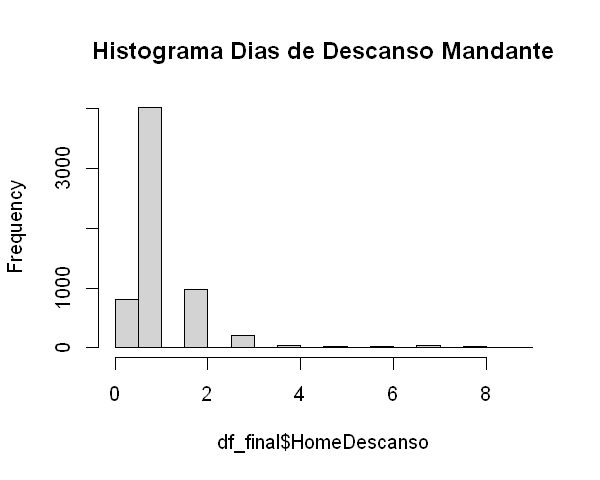

In [34]:
#Histograma Dias de Decanso Time da Casa
hist(df_final$HomeDescanso, main = "Histograma Dias de Descanso Mandante")

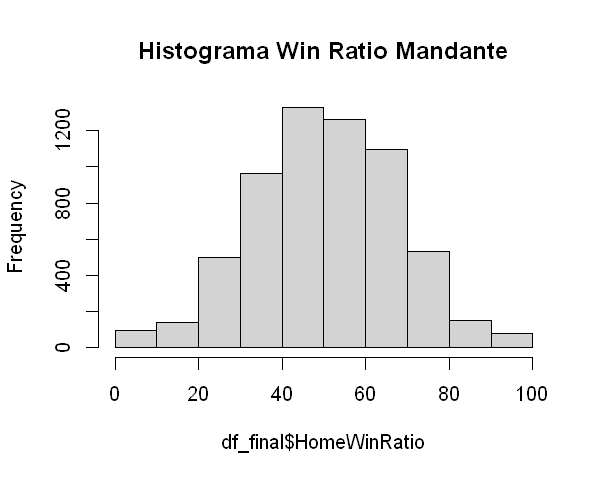

In [35]:
#Histograma Win Ratio Time da Casa
hist(df_final$HomeWinRatio, main = "Histograma Win Ratio Mandante")

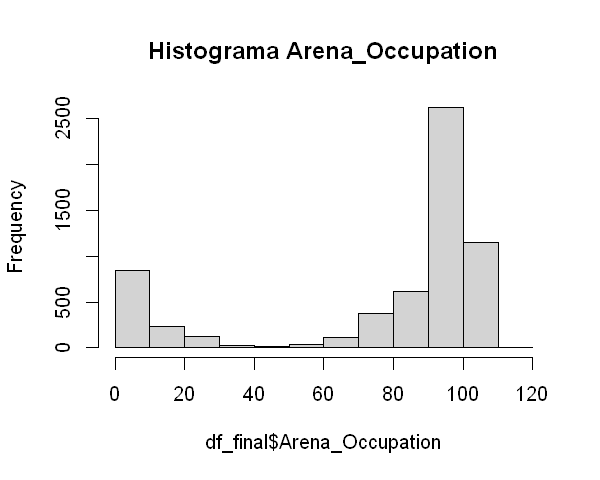

In [36]:
#Histograma Arena Occupation
hist(df_final$Arena_Occupation, main = "Histograma Arena_Occupation")

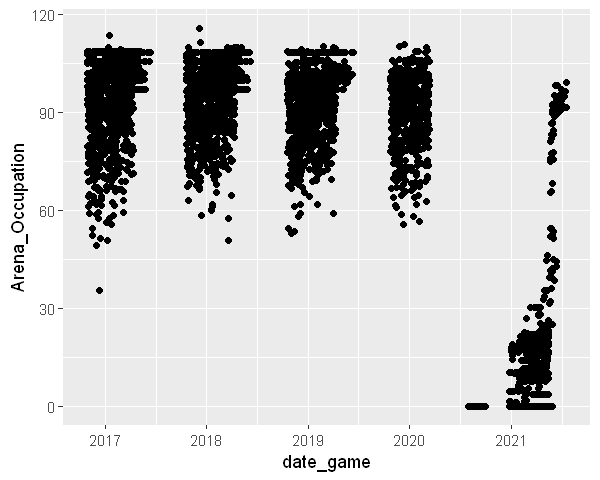

In [37]:
#Ocupacao da arena por dia de jogo
ggplot(df_final, aes(x=date_game, y=Arena_Occupation)) + 
    geom_point()

In [38]:
#Taxa de Vitoria Media do Time da Casa por Temporada
resumo <- df_final %>% group_by(SEASON) %>%  summarise('TaxaVitoriaMedia' = mean(Home_Win))
resumo

SEASON,TaxaVitoriaMedia
<chr>,<dbl>
2017,0.5831400
2018,0.5864198
2019,0.5895062
2020,0.5459459
2021,0.5463203


In [39]:
#Taxa de Vitoria Media do Time da Casa por Presencao ou Nao de torcida
resumo_torcida <- df_final %>% group_by(Fans_Presence) %>%  summarise('TaxaVitoriaMedia' = mean(Home_Win))
resumo_torcida

Fans_Presence,TaxaVitoriaMedia
<dbl>,<dbl>
0,0.5096953
1,0.5797716


In [40]:
#Cria Faixas de ocupacao da arena pelos fas e ve a taxa media de vitoria por faixa de ocupacao.
df_final <- df_final %>% mutate(
  ArenaOccupationGroup = case_when(
    Arena_Occupation >= 0  & Arena_Occupation <= 25 ~ '0-25% ocup.',
    Arena_Occupation > 25  & Arena_Occupation <= 50 ~ '25-50% ocup.',
    Arena_Occupation > 50  & Arena_Occupation <= 75 ~ '50-75% ocup.',
    Arena_Occupation > 75 ~ '75% + ocup.'))

resumo_ocupacao <- df_final %>% group_by(ArenaOccupationGroup) %>%  summarise('TaxaVitoriaMedia' = mean(Home_Win))
resumo_ocupacao

#adicionar coluna de frequencia

ArenaOccupationGroup,TaxaVitoriaMedia
<chr>,<dbl>
0-25% ocup.,0.5335570
25-50% ocup.,0.7000000
50-75% ocup.,0.5292208
75% + ocup.,0.5828261


Vemos que na temporada de 2020 temos uma menor taxa de vitoria dos times da casa, podendo ser uma indicacao do impacto da ausencia de torcida na bolha da NBA.Alem disso, vemos que em media a taxa de vitoria do timeda casa é maior quando há presenca de torcida (57% de vitoria com torcida contra 52% de vitoria sem torcida).

# 4. Modelagem dos Dados


Separandos os dados em treino e teste para avaliacao dos modelos criados.

Para a primeira abordagem (utilizacao da variavel ocupacao nas temporadas sem pandemia) os dados das primeiras duas temporadas disponveis (2016-17 e 2017-18) serao utilizadas como dados de treino e os dados da temporada 2018-19 sera nossos dados de teste.

Para a segunda abordagem (utilizacao da variavel fan presence) vamos utilizar 80% dos jogos para dados de treino e 20% para dados de teste.

In [41]:
#dados de teste e treino
df_treino_ab1 <- df_final[df_final$SEASON == 2017 |
                          df_final$SEASON == 2018,]
df_teste_ab1 <- df_final[df_final$SEASON==2019,]                    


df_treino_ab2 <- df_final[df_final$SEASON == 2020 | df_final$SEASON == 2021,] %>%  sample_frac(0.8)

df_suporte <- df_treino_ab2[,1:2]
df_suporte$DADOS_TREINO <- 1
df_suporte$date_game <- NULL

df_teste_ab2 <- merge(x = df_final[df_final$SEASON == 2020 | df_final$SEASON == 2021,],
                      y = df_suporte,
                      by = "game_id",
                      all.x = TRUE)

df_teste_ab2 <- df_teste_ab2[is.na(df_teste_ab2$DADOS_TREINO) == T,]

In [42]:
#verifica a variavel fans presence nos dados de treino e teste da abordagem 2
summary(df_teste_ab2[,c('Fans_Presence')])
summary(df_treino_ab2[,c('Fans_Presence')])

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   0.00    0.00    1.00    0.66    1.00    1.00 

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 0.0000  0.0000  1.0000  0.6865  1.0000  1.0000 

Como esperado para a abordagem 2, temos 33% dos jogos sem presenca de fans, tanto nos dados de treino quanto nos dados de teste

In [43]:
summary(df_teste_ab1[,c('Fans_Presence')])
summary(df_treino_ab1[,c('Fans_Presence')])

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
      1       1       1       1       1       1 

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
      1       1       1       1       1       1 

Como esperado para a abordagem 1 os dois conjuntos de dados apresentam todos os jogos com presenca de fans

In [44]:
#Seleciona apenas as colunas a serem utilizadas na modelagem
cols_ab1 <- c('Arena_Occupation','HomeWinStreak','HomeLossStreak','AwayWinStreak','AwayLossStreak','HomeWinRatio',
              'AwayWinRatio','HomeDescanso','AwayDescanso','Home_Win', 'FLAG_PLAYOFFS')

cols_ab2 <- c('Arena_Occupation','HomeWinStreak','HomeLossStreak','AwayWinStreak','AwayLossStreak','HomeWinRatio',
              'AwayWinRatio','HomeDescanso','AwayDescanso','Home_Win','Fans_Presence')

df_treino_ab1 <- df_treino_ab1[,cols_ab1]
df_teste_ab1 <- df_teste_ab1[,cols_ab1]


df_treino_ab2 <- df_treino_ab2[,cols_ab2]
df_teste_ab2 <- df_teste_ab2[,cols_ab2]

In [45]:
dim(df_teste_ab2)

[1] 453  11

In [46]:
#Normaliza os dados
cols_to_norm_ab1 <- c('Arena_Occupation','HomeWinStreak','HomeLossStreak','AwayWinStreak','AwayLossStreak','HomeWinRatio',
              'AwayWinRatio','HomeDescanso','AwayDescanso')

cols_to_norm_ab2 <- c('HomeWinStreak','HomeLossStreak','AwayWinStreak','AwayLossStreak','HomeWinRatio',
              'AwayWinRatio','HomeDescanso','AwayDescanso')


df_norm <- rbind(df_treino_ab1,df_teste_ab1)
df_norm <- as.data.frame(lapply(df_norm[,cols_to_norm_ab1],normalizar))

df_treino_ab1_norm <- cbind(df_norm[1:2589,],
                            'Home_Win_Label' = df_treino_ab1$Home_Win,
                            'FLAG_PLAYOFFS' = df_treino_ab1$FLAG_PLAYOFFS)
df_teste_ab1_norm <-  cbind(df_norm[2590:3885,],
                            'Home_Win_Label' = df_teste_ab1$Home_Win,
                            'FLAG_PLAYOFFS' = df_teste_ab1$FLAG_PLAYOFFS)

df_norm <- rbind(df_treino_ab2,df_teste_ab2)
df_norm <- as.data.frame(lapply(df_norm[,cols_to_norm_ab2],normalizar))

df_treino_ab2_norm <- cbind(df_norm[1:1812,],
                            'Home_Win_Label' = df_treino_ab2$Home_Win,
                            'Fans_Presence' = df_treino_ab2$Fans_Presence)
df_teste_ab2_norm <-  cbind(df_norm[1813:2265,],
                            'Home_Win_Label' = df_teste_ab2$Home_Win,
                            'Fans_Presence' = df_teste_ab2$Fans_Presence)

## 4.1 Modelo Abordagem 1 (Temporadas sem pandemia)

In [47]:
#Criando Modelo Base ABORDAGEM 1 - Probit
modelo_base <- glm(Home_Win_Label ~ ., 
                   family = binomial(link="probit"),
                   data = df_treino_ab1_norm)


summary(modelo_base)


Call:
glm(formula = Home_Win_Label ~ ., family = binomial(link = "probit"), 
    data = df_treino_ab1_norm)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-2.1751  -1.1973   0.7503   1.0041   2.1378  

Coefficients:
                 Estimate Std. Error z value Pr(>|z|)    
(Intercept)        0.2269     0.1832   1.238   0.2156    
Arena_Occupation   0.1490     0.2094   0.711   0.4769    
HomeWinStreak      0.3709     0.2495   1.487   0.1371    
HomeLossStreak    -0.3106     0.2954  -1.051   0.2932    
AwayWinStreak     -0.5264     0.2491  -2.113   0.0346 *  
AwayLossStreak    -0.2446     0.3047  -0.803   0.4220    
HomeWinRatio       1.3149     0.1747   7.526 5.22e-14 ***
AwayWinRatio      -1.4602     0.1780  -8.203 2.35e-16 ***
HomeDescanso       0.3641     0.2679   1.359   0.1742    
AwayDescanso      -0.3996     0.2549  -1.568   0.1169    
FLAG_PLAYOFFS      0.1601     0.1120   1.429   0.1530    
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

In [48]:
#Realizando previsoes para avaliar o modelo

#Previsoes nos dados de treino
pred_train <- predict(modelo_base, df_treino_ab1_norm, type = 'response')
pred_train <- ifelse(pred_train > 0.5, 1, 0)

#Previsoes corretas com dataset de treino
print(paste('Acuracia do Modelo nos dados de treino :',mean(pred_train == df_treino_ab1_norm$Home_Win_Label)))

#previsoes com dados de teste
pred_teste <- predict(modelo_base, df_teste_ab1_norm, type = 'response')
pred_teste <- ifelse(pred_teste > 0.5, 1, 0)

#previsoes corretas com dataset de teste
print(paste('Acuracia do Modelo nos dados de teste :',mean(pred_teste == df_teste_ab1_norm$Home_Win_Label)))

#confusion matrix
print('Matriz de confusão:')
table(pred_teste,df_teste_ab1_norm$Home_Win_Label)


[1] "Acuracia do Modelo nos dados de treino : 0.640401699497876"
[1] "Acuracia do Modelo nos dados de teste : 0.645061728395062"
[1] "Matriz de confusão:"


          
pred_teste   0   1
         0 205 133
         1 327 631

**Analisando o modelo base da abordagem 1:**

As únicas variáveis que se mostraram estatisticamente significativa foram as taxas de vitorias dos times e a sequencia de vitórias do time da casa. A taxa de vitória do time mandante possui impacto positivo nas chances desse time vencer, o que signfica que quanto maior a taxa de vitória desse time maior a chance dele vencer o jogo (o que faz todo sentido com o que é esperado de times que vencem mais). Da mesma forma a taxa de vitoria do time visitante possui impacto negativo nas chances do mandante vencer a partida. Por último a sequencia de vitorias do mandante aumenta as chances desse time vencer.

Analisando o impacto da taxa de ocupação da arena nas chances de vitoria do time mandante vemos que ela não é estatisticamente significante, o que pode ser indicativo que não há relaçao entre as chances de vitoria do time da casa e a ocupação da arena.

In [49]:
#Retirando as variaveis nao significativas e atualizando o modelo, porem mantendo a variavel arena_occupation.

modelo_base_2 <- glm(Home_Win_Label ~ HomeWinRatio + AwayWinRatio + HomeWinStreak + Arena_Occupation, 
                     family = binomial(link="probit"),
                     data = df_treino_ab1_norm)


summary(modelo_base_2)

#Realizando previsoes para avaliar o modelo

#Previsoes nos dados de treino
pred_train <- predict(modelo_base_2, df_treino_ab1_norm, type = 'response')
pred_train <- ifelse(pred_train > 0.5, 1, 0)

#Previsoes corretas com dataset de treino
print(paste('Acuracia do Modelo nos dados de treino :',mean(pred_train == df_treino_ab1_norm$Home_Win_Label)))

#previsoes com dados de teste
pred_teste <- predict(modelo_base_2, df_teste_ab1_norm, type = 'response')
pred_teste <- ifelse(pred_teste > 0.5, 1, 0)

#previsoes corretas com dataset de teste
print(paste('Acuracia do Modelo nos dados de teste :',mean(pred_teste == df_teste_ab1_norm$Home_Win_Label)))

#confusion matrix
table(pred_teste,df_teste_ab1_norm$Home_Win_Label)


Call:
glm(formula = Home_Win_Label ~ HomeWinRatio + AwayWinRatio + 
    HomeWinStreak + Arena_Occupation, family = binomial(link = "probit"), 
    data = df_treino_ab1_norm)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-2.1728  -1.1892   0.7552   1.0123   2.1295  

Coefficients:
                 Estimate Std. Error z value Pr(>|z|)    
(Intercept)        0.1285     0.1640   0.784   0.4333    
HomeWinRatio       1.4023     0.1658   8.456   <2e-16 ***
AwayWinRatio      -1.5053     0.1551  -9.703   <2e-16 ***
HomeWinStreak      0.4279     0.2393   1.788   0.0737 .  
Arena_Occupation   0.1673     0.2077   0.805   0.4207    
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 3514.3  on 2588  degrees of freedom
Residual deviance: 3308.8  on 2584  degrees of freedom
AIC: 3318.8

Number of Fisher Scoring iterations: 4


[1] "Acuracia do Modelo nos dados de treino : 0.639629200463499"
[1] "Acuracia do Modelo nos dados de teste : 0.652777777777778"


          
pred_teste   0   1
         0 211 129
         1 321 635

**Analise do modelo V2 da abordagem 1:**

A variavel de taxa de ocupacao da arena continuou sendo nao significante, mesmo no modelo com menos variaveis. Isso pode ser consequencia das arenas estarem sempre com pelo menos 50% de ocupacao (como visto na analise exploratoria),assim parece taxas de ocupações maiores nao tem efeito sobre as chances de vitoria, ja que nao temos jogos com baixa ocupacao ou sem ocupacao nas temporadas entre 2017 e 2019. <br/> 
Ou seja, a variável nao apresenta grandes diferenças entre os jogos, não sendo relevante para as chances de vitoria do time da casa.

Vamos tentar novos algoritmos afim de aumentar a acurácia dos nossos modelos. Vamos testar random forest e xgboost.

**Investigar outros modelos para essa abordagem --> foca na classificacao para depois pensarmos no efeito do publico. Compara casos proximos e ver o delta de ocupacao da arena**

In [133]:
#criando modelo random forest basse
rf <- randomForest(
  as.factor(Home_Win_Label) ~ .,
  data = df_treino_ab1_norm,
)
rf


Call:
 randomForest(formula = as.factor(Home_Win_Label) ~ ., data = df_treino_ab1_norm,      ) 
               Type of random forest: classification
                     Number of trees: 500
No. of variables tried at each split: 3

        OOB estimate of  error rate: 37.62%
Confusion matrix:
    0    1 class.error
0 506  569   0.5293023
1 405 1109   0.2675033

In [135]:
rf_treino_pred = predict(rf, df_treino_ab1_norm)
#rf_treino_pred <- ifelse(rf_treino_pred > 0.5, 1, 0)

#Previsoes corretas com dataset de treino
print(paste('Acuracia do Modelo nos dados de treino :',mean(rf_treino_pred == df_treino_ab1_norm$Home_Win_Label)))

#previsoes nos dados de teste
rf_teste_pred = predict(rf, df_teste_ab1_norm)
#rf_teste_pred <- ifelse(rf_teste_pred > 0.5, 1, 0)

#previsoes corretas com dataset de teste
print(paste('Acuracia do Modelo nos dados de teste :',mean(rf_teste_pred == df_teste_ab1_norm$Home_Win_Label)))


[1] "Acuracia do Modelo nos dados de treino : 0.999227500965624"
[1] "Acuracia do Modelo nos dados de teste : 0.609567901234568"


Modelo base de random forest apresentou overfitting, assim vamos ajustar os parametros afim de otimizar o modelo

In [136]:
rf <- randomForest(
  as.factor(Home_Win_Label) ~ .,
  data = df_treino_ab1_norm,
    maxnodes = 30,
    mtry = 2,
    ntree=1000
)
rf


Call:
 randomForest(formula = as.factor(Home_Win_Label) ~ ., data = df_treino_ab1_norm,      maxnodes = 30, mtry = 2, ntree = 1000) 
               Type of random forest: classification
                     Number of trees: 1000
No. of variables tried at each split: 2

        OOB estimate of  error rate: 36.46%
Confusion matrix:
    0    1 class.error
0 404  671    0.624186
1 273 1241    0.180317

In [137]:
rf_treino_pred = predict(rf, df_treino_ab1_norm)
#rf_treino_pred <- ifelse(rf_treino_pred > 0.5, 1, 0)

#Previsoes corretas com dataset de treino
print(paste('Acuracia do Modelo nos dados de treino :',mean(rf_treino_pred == df_treino_ab1_norm$Home_Win_Label)))

#confusion matrix
table(rf_treino_pred, df_treino_ab1_norm$Home_Win_Label)

#previsoes nos dados de teste
rf_teste_pred = predict(rf, df_teste_ab1_norm)
#rf_teste_pred <- ifelse(rf_teste_pred > 0.5, 1, 0)

#previsoes corretas com dataset de teste
print(paste('Acuracia do Modelo nos dados de teste :',mean(rf_teste_pred == df_teste_ab1_norm$Home_Win_Label)))

#confusion matrix

[1] "Acuracia do Modelo nos dados de treino : 0.676322904596369"


              
rf_treino_pred    0    1
             0  465  228
             1  610 1286

[1] "Acuracia do Modelo nos dados de teste : 0.639660493827161"


O Modelo Random Forest nao apresentou bons resultados de acuracia nos dados de teste, quando corrigido para evitar overfitting. Sua performance foi parecida com os modelos Logit. Iremos testar agora o modelo xgboost, afim de aumentar a acurácia em dados de teste.

In [138]:
#criando modelo com xgboost
vars <- c('Arena_Occupation','HomeWinStreak','HomeLossStreak','AwayWinStreak','AwayLossStreak','HomeWinRatio',
              'AwayWinRatio','HomeDescanso','AwayDescanso')

modelo_xgb <- xgboost(data = as.matrix(df_treino_ab1_norm[vars]),
                     label = df_treino_ab1_norm$Home_Win_Label,
                     max_depth = 10,
                     gamma = 1,
                     eta = 1,
                     nthread =8,
                     nround = 300,
                     min_child_weight =0,
                     objective = "binary:logistic",
                     eval_metric = 'error',
                     verbosity = 0)

#previsoes nos dados de treino
rf_treino_pred = predict(modelo_xgb, as.matrix(df_treino_ab1_norm[vars]))
rf_treino_pred <- ifelse(rf_treino_pred > 0.4, 1, 0)

#Previsoes corretas com dataset de treino
print(paste('Acuracia do Modelo nos dados de treino :',mean(rf_treino_pred == df_treino_ab1_norm$Home_Win_Label)))

#confusion matrix
table(rf_treino_pred, df_treino_ab1_norm$Home_Win_Label)

#previsoes nos dados de teste
rf_teste_pred = predict(modelo_xgb, as.matrix(df_teste_ab1_norm[vars]))
rf_teste_pred <- ifelse(rf_teste_pred > 0.4, 1, 0)

#previsoes corretas com dataset de teste
print(paste('Acuracia do Modelo nos dados de teste :',mean(rf_teste_pred == df_teste_ab1_norm$Home_Win_Label)))

#confusion matrix
table(rf_teste_pred, df_teste_ab1_norm$Home_Win_Label)

[1]	train-error:0.187331 
[2]	train-error:0.144071 
[3]	train-error:0.113171 
[4]	train-error:0.097721 
[5]	train-error:0.083816 
[6]	train-error:0.076091 
[7]	train-error:0.067980 
[8]	train-error:0.059869 
[9]	train-error:0.054075 
[10]	train-error:0.047509 
[11]	train-error:0.040942 
[12]	train-error:0.030127 
[13]	train-error:0.026651 
[14]	train-error:0.023947 
[15]	train-error:0.022016 
[16]	train-error:0.020085 
[17]	train-error:0.017767 
[18]	train-error:0.018154 
[19]	train-error:0.018154 
[20]	train-error:0.017767 
[21]	train-error:0.017381 
[22]	train-error:0.015836 
[23]	train-error:0.016995 
[24]	train-error:0.013132 
[25]	train-error:0.012360 
[26]	train-error:0.012360 
[27]	train-error:0.012746 
[28]	train-error:0.011974 
[29]	train-error:0.011974 
[30]	train-error:0.011974 
[31]	train-error:0.011974 
[32]	train-error:0.011974 
[33]	train-error:0.011974 
[34]	train-error:0.011974 
[35]	train-error:0.011974 
[36]	train-error:0.011974 
[37]	train-error:0.011974 
[38]	train

[1] "Acuracia do Modelo nos dados de treino : 0.982232522209347"


              
rf_treino_pred    0    1
             0 1030    1
             1   45 1513

[1] "Acuracia do Modelo nos dados de teste : 0.566358024691358"


             
rf_teste_pred   0   1
            0 193 223
            1 339 541

O xgboost apresenta um problema maior ainda de overfiting. Mesmo realizando a diminuição da profundidade o modelo nao se ajusta bem, chegando a no maximo uma acuracia de 65% nos dados de treino. O último modelo a ser testado sera o Naive Bayes.

In [145]:
nb <- naiveBayes(Home_Win_Label ~ HomeWinRatio + AwayWinRatio + HomeWinStreak + Arena_Occupation,
                 data = df_treino_ab1_norm)
nb


Naive Bayes Classifier for Discrete Predictors

Call:
naiveBayes.default(x = X, y = Y, laplace = laplace)

A-priori probabilities:
Y
        0         1 
0.4152182 0.5847818 

Conditional probabilities:
   HomeWinRatio
Y        [,1]      [,2]
  0 0.4667346 0.1726016
  1 0.5375041 0.1726497

   AwayWinRatio
Y        [,1]      [,2]
  0 0.5467707 0.1713882
  1 0.4828374 0.1665173

   HomeWinStreak
Y         [,1]      [,2]
  0 0.05751026 0.1032278
  1 0.08368949 0.1314852

   Arena_Occupation
Y        [,1]      [,2]
  0 0.7392001 0.1286833
  1 0.7506753 0.1280134


In [144]:
nb_treino_pred = predict(nb, df_treino_ab1_norm)
#rf_treino_pred <- ifelse(rf_treino_pred > 0.5, 1, 0)

#Previsoes corretas com dataset de treino
print(paste('Acuracia do Modelo nos dados de treino :',mean(nb_treino_pred == df_treino_ab1_norm$Home_Win_Label)))

#previsoes nos dados de teste
nb_teste_pred = predict(nb, df_teste_ab1_norm)
#rf_teste_pred <- ifelse(rf_teste_pred > 0.5, 1, 0)

#previsoes corretas com dataset de teste
print(paste('Acuracia do Modelo nos dados de teste :',mean(nb_teste_pred == df_teste_ab1_norm$Home_Win_Label)))

#confusion matrix

[1] "Acuracia do Modelo nos dados de treino : 0.640787949015064"
[1] "Acuracia do Modelo nos dados de teste : 0.640432098765432"


A performance do modelo naiveBayes também foi muito parecida com os resultados da regressao logistica e do random forest. Isso pode apontar para a necessidade de mais dados para conseguirmos obter melhores acurácias.

## 4.2 Modelo Abordagem 2 (Temporada 2020 e 2021 com pandemia e jogos sem torcida)

In [49]:
#Criando Modelo Base ABORDAGEM 2 - Probit
modelo_base <- glm(Home_Win_Label ~ ., 
                   family = binomial(link="probit"),
                   data = df_treino_ab2_norm)


summary(modelo_base)


Call:
glm(formula = Home_Win_Label ~ ., family = binomial(link = "probit"), 
    data = df_treino_ab2_norm)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-2.3582  -1.1539   0.7217   1.0698   2.2281  

Coefficients:
               Estimate Std. Error z value Pr(>|z|)    
(Intercept)     0.05763    0.15531   0.371    0.711    
HomeWinStreak   0.32562    0.37690   0.864    0.388    
HomeLossStreak -0.47110    0.35220  -1.338    0.181    
AwayWinStreak   0.32439    0.33487   0.969    0.333    
AwayLossStreak  0.38800    0.27060   1.434    0.152    
HomeWinRatio    1.43658    0.20116   7.141 9.24e-13 ***
AwayWinRatio   -1.38821    0.20176  -6.881 5.96e-12 ***
HomeDescanso   -0.11982    0.26307  -0.455    0.649    
AwayDescanso   -0.39177    0.39051  -1.003    0.316    
Fans_Presence   0.06191    0.06502   0.952    0.341    
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 2

In [52]:
#Realizando previsoes para avaliar o modelo

#Previsoes nos dados de treino
pred_train <- predict(modelo_base, df_treino_ab2_norm, type = 'response')
pred_train <- ifelse(pred_train > 0.5, 1, 0)

#Previsoes corretas com dataset de treino
print(paste('Acuracia do Modelo nos dados de treino :',mean(pred_train == df_treino_ab2_norm$Home_Win_Label)))

#previsoes com dados de teste
pred_teste <- predict(modelo_base, df_teste_ab2_norm, type = 'response')
pred_teste <- ifelse(pred_teste > 0.5, 1, 0)

#previsoes corretas com dataset de teste
print(paste('Acuracia do Modelo nos dados de teste :',mean(pred_teste == df_teste_ab2_norm$Home_Win_Label)))

#confusion matrix
print('Matriz de confusão:')
table(pred_teste,df_teste_ab2_norm$Home_Win_Label)


[1] "Acuracia do Modelo nos dados de treino : 0.625827814569536"
[1] "Acuracia do Modelo nos dados de teste : 0.65121412803532"
[1] "Matriz de confusão:"


          
pred_teste   0   1
         0  97  65
         1  93 198

**Analise do modelo base da Abordagem 2:**

Assim como na abordagem 1 a grande maioria das variaveis se mostraram nao significativas, porém a variaveis que indica presenca ou nao de fans se mostrou signficativa com impacto positivo sobre as chances de vitoria do time da casa. <br/>

Vamos criar um novo modelo, retirando as variaveis nao significativas e a partir do novo modelo poderemos calcular o efeito marginal médio e o efeito marginal na média para mensurar o tamanho do impacto da presença de fans que já verificamos ser positivo.


In [53]:
#Retirando as variaveis nao significativas e atualizando o modelo, porem mantendo a variavel fans_presence

modelo_base_2 <- glm(Home_Win_Label ~ HomeWinRatio + AwayWinRatio + HomeLossStreak + Fans_Presence, 
                     family = binomial(link="probit"),
                     data = df_treino_ab2_norm)


summary(modelo_base_2)

#Realizando previsoes para avaliar o modelo

#Previsoes nos dados de treino
pred_train <- predict(modelo_base_2, df_treino_ab2_norm, type = 'response')
pred_train <- ifelse(pred_train > 0.5, 1, 0)

#Previsoes corretas com dataset de treino
print(paste('Acuracia do Modelo nos dados de treino :',mean(pred_train == df_treino_ab2_norm$Home_Win_Label)))

#previsoes com dados de teste
pred_teste <- predict(modelo_base_2, df_teste_ab2_norm, type = 'response')
pred_teste <- ifelse(pred_teste > 0.5, 1, 0)

#previsoes corretas com dataset de teste
print(paste('Acuracia do Modelo nos dados de teste :',mean(pred_teste == df_teste_ab2_norm$Home_Win_Label)))

#confusion matrix
table(pred_teste,df_teste_ab2_norm$Home_Win_Label)


Call:
glm(formula = Home_Win_Label ~ HomeWinRatio + AwayWinRatio + 
    HomeLossStreak + Fans_Presence, family = binomial(link = "probit"), 
    data = df_treino_ab2_norm)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-2.3674  -1.1585   0.7386   1.0659   2.2482  

Coefficients:
               Estimate Std. Error z value Pr(>|z|)    
(Intercept)     0.07647    0.14110   0.542    0.588    
HomeWinRatio    1.47274    0.19108   7.708 1.28e-14 ***
AwayWinRatio   -1.42831    0.17828  -8.012 1.13e-15 ***
HomeLossStreak -0.54044    0.33666  -1.605    0.108    
Fans_Presence   0.07165    0.06459   1.109    0.267    
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 2501.7  on 1811  degrees of freedom
Residual deviance: 2357.6  on 1807  degrees of freedom
AIC: 2367.6

Number of Fisher Scoring iterations: 4


[1] "Acuracia do Modelo nos dados de treino : 0.624724061810154"
[1] "Acuracia do Modelo nos dados de teste : 0.646799116997792"


          
pred_teste   0   1
         0  94  64
         1  96 199

O modelo continuou com baixa acurácia nos dados de teste. Assim, outros algoritmos serão testados para obtermos uma melhor acurácia dos modelos. Serão testados os algoritmos random forest,xgboost e naive bayes.

In [146]:
#criação do modelo base de random forest
rf <- randomForest(
  as.factor(Home_Win_Label) ~ .,
  data = df_treino_ab2_norm,
)
rf


Call:
 randomForest(formula = as.factor(Home_Win_Label) ~ ., data = df_treino_ab2_norm,      ) 
               Type of random forest: classification
                     Number of trees: 500
No. of variables tried at each split: 3

        OOB estimate of  error rate: 41.17%
Confusion matrix:
    0   1 class.error
0 457 383   0.4559524
1 363 609   0.3734568

In [147]:
rf_treino_pred = predict(rf, df_treino_ab2_norm)
#rf_treino_pred <- ifelse(rf_treino_pred > 0.5, 1, 0)

#Previsoes corretas com dataset de treino
print(paste('Acuracia do Modelo nos dados de treino :',mean(rf_treino_pred == df_treino_ab2_norm$Home_Win_Label)))

#previsoes nos dados de teste
rf_teste_pred = predict(rf, df_teste_ab2_norm)
#rf_teste_pred <- ifelse(rf_teste_pred > 0.5, 1, 0)

#previsoes corretas com dataset de teste
print(paste('Acuracia do Modelo nos dados de teste :',mean(rf_teste_pred == df_teste_ab2_norm$Home_Win_Label)))


[1] "Acuracia do Modelo nos dados de treino : 0.997792494481236"
[1] "Acuracia do Modelo nos dados de teste : 0.618101545253863"


Modelo base de random forest apresentou overfitting, assim vamos ajustar os parametros afim de otimizar o modelo

In [151]:
rf <- randomForest(
  as.factor(Home_Win_Label) ~ .,
  data = df_treino_ab2_norm,
    maxnodes = 30,
    mtry = 2,
    ntree=1000
)
rf


Call:
 randomForest(formula = as.factor(Home_Win_Label) ~ ., data = df_treino_ab2_norm,      maxnodes = 30, mtry = 2, ntree = 1000) 
               Type of random forest: classification
                     Number of trees: 1000
No. of variables tried at each split: 2

        OOB estimate of  error rate: 38.69%
Confusion matrix:
    0   1 class.error
0 421 419   0.4988095
1 282 690   0.2901235

In [152]:
rf_treino_pred = predict(rf, df_treino_ab2_norm)
#rf_treino_pred <- ifelse(rf_treino_pred > 0.5, 1, 0)

#Previsoes corretas com dataset de treino
print(paste('Acuracia do Modelo nos dados de treino :',mean(rf_treino_pred == df_treino_ab2_norm$Home_Win_Label)))

#previsoes nos dados de teste
rf_teste_pred = predict(rf, df_teste_ab2_norm)
#rf_teste_pred <- ifelse(rf_teste_pred > 0.5, 1, 0)

#previsoes corretas com dataset de teste
print(paste('Acuracia do Modelo nos dados de teste :',mean(rf_teste_pred == df_teste_ab2_norm$Home_Win_Label)))


[1] "Acuracia do Modelo nos dados de treino : 0.670529801324503"
[1] "Acuracia do Modelo nos dados de teste : 0.624724061810154"


O Modelo Random Forest nao apresentou bons resultados de acuracia nos dados de teste, quando corrigido para evitar overfitting. Sua performance foi parecida com os modelos Logit. Iremos testar agora o modelo xgboost, afim de aumentar a acurácia em dados de teste.

In [154]:
#criando modelo com xgboost
vars <- c('HomeWinStreak','HomeLossStreak','AwayWinStreak','AwayLossStreak','HomeWinRatio',
              'AwayWinRatio','HomeDescanso','AwayDescanso')

modelo_xgb <- xgboost(data = as.matrix(df_treino_ab2_norm[vars]),
                     label = df_treino_ab2_norm$Home_Win_Label,
                     max_depth = 10,
                     gamma = 1,
                     eta = 1,
                     nthread =8,
                     nround = 300,
                     min_child_weight =0,
                     objective = "binary:logistic",
                     eval_metric = 'error',
                     verbosity = 0)

#previsoes nos dados de treino
rf_treino_pred = predict(modelo_xgb, as.matrix(df_treino_ab2_norm[vars]))
rf_treino_pred <- ifelse(rf_treino_pred > 0.4, 1, 0)

#Previsoes corretas com dataset de treino
print(paste('Acuracia do Modelo nos dados de treino :',mean(rf_treino_pred == df_treino_ab2_norm$Home_Win_Label)))

#confusion matrix
table(rf_treino_pred, df_treino_ab2_norm$Home_Win_Label)

#previsoes nos dados de teste
rf_teste_pred = predict(modelo_xgb, as.matrix(df_teste_ab2_norm[vars]))
rf_teste_pred <- ifelse(rf_teste_pred > 0.4, 1, 0)

#previsoes corretas com dataset de teste
print(paste('Acuracia do Modelo nos dados de teste :',mean(rf_teste_pred == df_teste_ab2_norm$Home_Win_Label)))

#confusion matrix
table(rf_teste_pred, df_teste_ab2_norm$Home_Win_Label)

[1]	train-error:0.205850 
[2]	train-error:0.153422 
[3]	train-error:0.120861 
[4]	train-error:0.091611 
[5]	train-error:0.079470 
[6]	train-error:0.077815 
[7]	train-error:0.064018 
[8]	train-error:0.056843 
[9]	train-error:0.056843 
[10]	train-error:0.052980 
[11]	train-error:0.040839 
[12]	train-error:0.036424 
[13]	train-error:0.034216 
[14]	train-error:0.034768 
[15]	train-error:0.032561 
[16]	train-error:0.032009 
[17]	train-error:0.032009 
[18]	train-error:0.032009 
[19]	train-error:0.032009 
[20]	train-error:0.032009 
[21]	train-error:0.032009 
[22]	train-error:0.032009 
[23]	train-error:0.032009 
[24]	train-error:0.032009 
[25]	train-error:0.032009 
[26]	train-error:0.032009 
[27]	train-error:0.032009 
[28]	train-error:0.032009 
[29]	train-error:0.032009 
[30]	train-error:0.032009 
[31]	train-error:0.032009 
[32]	train-error:0.032009 
[33]	train-error:0.032009 
[34]	train-error:0.032009 
[35]	train-error:0.032009 
[36]	train-error:0.032009 
[37]	train-error:0.032009 
[38]	train

[1] "Acuracia do Modelo nos dados de treino : 0.953090507726269"


              
rf_treino_pred   0   1
             0 763   8
             1  77 964

[1] "Acuracia do Modelo nos dados de teste : 0.576158940397351"


             
rf_teste_pred   0   1
            0  92  96
            1  96 169

O xgboost apresenta um problema maior ainda de overfitting. O último modelo a ser testado sera o Naive Bayes.

In [156]:
nb <- naiveBayes(Home_Win_Label ~ HomeWinRatio + AwayWinRatio + HomeWinStreak + Fans_Presence,
                 data = df_treino_ab2_norm)
nb


Naive Bayes Classifier for Discrete Predictors

Call:
naiveBayes.default(x = X, y = Y, laplace = laplace)

A-priori probabilities:
Y
        0         1 
0.4635762 0.5364238 

Conditional probabilities:
   HomeWinRatio
Y        [,1]      [,2]
  0 0.4691878 0.1742839
  1 0.5366419 0.1731330

   AwayWinRatio
Y        [,1]      [,2]
  0 0.5507918 0.1736113
  1 0.4855853 0.1729543

   HomeWinStreak
Y         [,1]       [,2]
  0 0.04973545 0.08782599
  1 0.07653178 0.11474811

   Fans_Presence
Y        [,1]      [,2]
  0 0.6595238 0.4741517
  1 0.7098765 0.4540528


In [157]:
nb_treino_pred = predict(nb, df_treino_ab2_norm)
#rf_treino_pred <- ifelse(rf_treino_pred > 0.5, 1, 0)

#Previsoes corretas com dataset de treino
print(paste('Acuracia do Modelo nos dados de treino :',mean(nb_treino_pred == df_treino_ab2_norm$Home_Win_Label)))

#previsoes nos dados de teste
nb_teste_pred = predict(nb, df_teste_ab2_norm)
#rf_teste_pred <- ifelse(rf_teste_pred > 0.5, 1, 0)

#previsoes corretas com dataset de teste
print(paste('Acuracia do Modelo nos dados de teste :',mean(nb_teste_pred == df_teste_ab2_norm$Home_Win_Label)))

#confusion matrix

[1] "Acuracia do Modelo nos dados de treino : 0.614238410596026"
[1] "Acuracia do Modelo nos dados de teste : 0.589403973509934"


A performance do modelo naiveBayes também foi muito parecida com os resultados da regressao logistica e do random forest. Isso pode apontar para a necessidade de mais dados para conseguirmos obter melhores acurácias. Os resultados da abordagem dois foram muito parecidos com os da abordagem 1. De todos os algoritmos testado o que obteve melhor performance foi a regressão logística. Poderíamos entao utilizar esses modelos para tentar identificar se há um impacto positivo na presença de torcida.